In [35]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import hw1_helper


from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False) # set to False if latex is not set up on your computer

## Visualize data

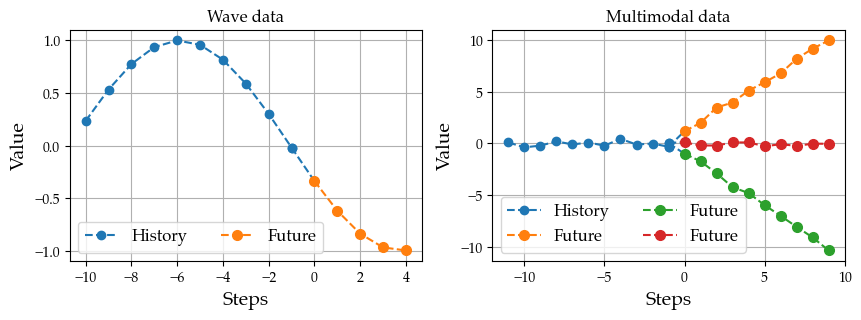

In [36]:
with open("data/hw1/wave_data_train.pickle", 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]

index = 1
history_length = history.shape[-1]
future_length = future.shape[-1]
ts_history = np.arange(-history_length,0)
ts_future = np.arange(future_length)

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(ts_history, history[index], marker='o', linestyle='--', label="History")
plt.plot([-1,0], [history[index][-1], future[index][0]], marker='o', linestyle='--', color="C0")
plt.plot(ts_future, future[index], markersize=7, marker='o', linestyle='--', label="Future")

plt.xlabel('Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, ncols=2)
plt.title("Wave data")
plt.grid(True)
# plt.show()



with open("data/hw1/multimodal_data_test.pickle", 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]


index = 1
history_length = history.shape[-1]
future_length = future.shape[-1]
ts_history = np.arange(-history_length,0)
ts_future = np.arange(future_length)

plt.subplot(1,2,2)
plt.plot(ts_history, history[index], marker='o', linestyle='--', label="History")
for i in range(3):
    plt.plot([-1,0], [history[i*100 + index][-1], future[i*100 + index][0]], marker='o', linestyle='--', color="C0")
    plt.plot(ts_future, future[i*100 + index], markersize=7, marker='o', linestyle='--', label="Future")

plt.xlabel('Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, ncols=2)
plt.title("Multimodal data")
plt.grid(True)
plt.show()


## Regression with sinusoidal trajectories

In this problem, you will learn a regular MLP to regress on sinusoidal data

In [37]:
# feel free to poke around the data
train_data = hw1_helper.TrajectoryData("data/hw1/wave_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/wave_data_test")

history_length = 10  # 10 pts per history vector
future_length = 5  # 5 pts per future vector 
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 10000 examples
Test set has 500 examples


In [38]:
print(test_data.history)

tensor([[ 0.9845,  0.9860,  0.8717,  ..., -0.6152, -0.8452, -0.9760],
        [ 0.1716, -0.1301, -0.4198,  ..., -0.9299, -0.7779, -0.5551],
        [ 0.4470,  0.1505, -0.1605,  ..., -0.9885, -0.8941, -0.7132],
        ...,
        [-0.9888, -1.0000, -0.9888,  ..., -0.6228, -0.4991, -0.3643],
        [ 0.8536,  0.8226,  0.7890,  ...,  0.5850,  0.5380,  0.4892],
        [-0.9993, -0.9686, -0.8583,  ...,  0.3950,  0.6393,  0.8312]])


### Simple MLP predictor

Multilayer perceptron - 2 layers
Input is entire data vector
Output is future trajectory vector

In [39]:
# Define a simple MLP model
from torch import nn
class MLP(nn.Module):
    def __init__(self, history_length, future_length, hidden_size=32):
        super(MLP, self).__init__()

        model = nn.Sequential()
        model.add_module("dense1", nn.Linear(history_length, history_length))
        model.add_module("act1", nn.ReLU())
        model.add_module("dense2", nn.Linear(history_length, future_length))
        self.model = model


    def forward(self, x):
        return self.model(x)



In [54]:
hidden_size = 12
history_length = 10
future_length = 5

model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 50
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [55]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)


Epoch [1/50], Step [0/313], Loss: 0.5114
Epoch [1/50], Step [20/313], Loss: 0.4872
Epoch [1/50], Step [40/313], Loss: 0.4392
Epoch [1/50], Step [60/313], Loss: 0.4498
Epoch [1/50], Step [80/313], Loss: 0.3580
Epoch [1/50], Step [100/313], Loss: 0.3657
Epoch [1/50], Step [120/313], Loss: 0.2790
Epoch [1/50], Step [140/313], Loss: 0.2465
Epoch [1/50], Step [160/313], Loss: 0.2206
Epoch [1/50], Step [180/313], Loss: 0.2351
Epoch [1/50], Step [200/313], Loss: 0.2442
Epoch [1/50], Step [220/313], Loss: 0.1327
Epoch [1/50], Step [240/313], Loss: 0.1786
Epoch [1/50], Step [260/313], Loss: 0.1726
Epoch [1/50], Step [280/313], Loss: 0.1436
Epoch [1/50], Step [300/313], Loss: 0.1170
Epoch 1 completed with average loss: 0.2853
Epoch [2/50], Step [0/313], Loss: 0.1189
Epoch [2/50], Step [20/313], Loss: 0.0845
Epoch [2/50], Step [40/313], Loss: 0.0624
Epoch [2/50], Step [60/313], Loss: 0.1153
Epoch [2/50], Step [80/313], Loss: 0.0624
Epoch [2/50], Step [100/313], Loss: 0.0602
Epoch [2/50], Step [12

In [51]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# Visualize prediction on test data
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-11, 5]
ylims = [-2,2]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 0.0006


interactive(children=(IntSlider(value=0, description='Index:', max=499), Output()), _dom_classes=('widget-inte…

<function hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

(a) Implement a simple MLP (≈ 2 layers) and train it on the wave data. Describe your MLP architecture.
Report the test loss and include some plots showing the prediction on the test set. Briefly justify your
choice of hyperparameters.

The MLP architecture I chose was a simple 2-layer perceptron with no hidden layers. The input layer takes in the history vector with 10 elements and outputs 10 elements. This is then fed into the ReLU activation function with size 10 as well. The output from the ReLU activation layer is then input into the second (last) layer which takes an input of 10 elements and outputs the predicted future trajectory with 5 elements.

Average loss of 0.0005

Increased number of epochs to 50 and size of hidden dim to 12 because these values resulted in a lower loss. I kept the learning rate the same as 0.001, there were no signs that the learning rate was too large (increasing loss)




(b) Briefly describe some potential benefits and limitations of using MLPs as the core architecture for
human behavior prediction.

Some benefits of MLPs for human behavior prediction are interpretability, weights on the hidden layer might provide some insight on more important/less important features of the data. In addition, MLPs are relatively easy to construct and train, making it a more accessible model to use and understand. 

Some drawbacks of MLPs in the context of human behavior prediction is it does not take into account any probabilities for the human making different actions. There is a single output defined purely by the learned weights and the same input will always result in the same output. Since human behavior is extremely stochastic, this type of model could be incorrect when 'edge' cases of the human are encountered.

### Simple LSTM predictor

(a) Implement a simple prediction model that uses an LSTM to encode the trajectory history and another LSTM to decode the output. Describe your LSTM architecture. Report the test loss and include some plots showing the prediction on the test set. Briefly justify your choice of hyperparameters.

The LSTM architecture I implemented used the encoder to generate hidden and cell states (initial values for decoder). Then used the decoder with the hidden and cell states to generate it's output. The output was considered as a single time step and then fed back into the decoder with the updated hidden and cell states. The decoder output was projected into the output dim (1), then directly used as one element of the time series we predicted.

Test loss = 0.005

Increased the number of hidden dim to 25 from 4 which seemed to reduce the loss from 0.0139 to 0.005. No other changes to the default epochs or learning rate. 

(b) Briefly describe some potential benefits and limitations of using RNNs/LSTMs as the core architecture for human behavior prediction?

LSTMs might be beneficial for human behavior prediction due to its ability to process time series data and have 'memory' of previous inputs. In the context of human-robot interaction, this might be useful for remember some information about the past and having that inform the current prediction -- rather than the MLP which is more static. 

(c) What happens if you choose a prediction horizon that is longer than the training data? Include a plot of your prediction with an extended prediction horizon.

Choosing a prediction horizon of 20, it seems to predict some interesting futures up until the 10th time step, where the predictions start to flatten out to a steady-state value.

In [79]:
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        # Encoder
        self.encoder = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, batch_first=True)
        
        # Decoder
        self.decoder = nn.LSTM(input_size=self.output_dim, hidden_size=self.hidden_dim, batch_first=True)
        
        # Projection
        self.projection = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x, t_max, y=None, prob=1.):
        """
        Forward pass of the LSTM model.
        x: The input sequence [batch_size, lookback_steps, input_dim]
        t_max: Maximum time steps to predict
        y: The target sequence for teacher forcing [batch_size, prediction_steps, output_dim]
        prob: Probability to apply teacher forcing (0 to 1).
        """
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)
        if y is not None and len(y.shape) == 2:
            y = y.unsqueeze(-1)

        batch_size = x.size(0)
        ys = []  # Collect outputs

        # Encoder: Get the hidden and cell states
        _, (hidden, cell) = self.encoder(x)

        # Initialize decoder input as zeros
        decoder_input = torch.zeros(batch_size, 1, self.output_dim, device=x.device)

        # Decoder loop for t_max steps
        for t in range(t_max):
            decoder_out, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            projection = self.projection(decoder_out)  # Project hidden state to output
            ys.append(projection)

            # Teacher forcing
            use_teacher_forcing = torch.rand(1).item() < prob
            if use_teacher_forcing and y is not None:
                decoder_input = y[:, t:t+1, :]  # Use ground truth as input
            else:
                decoder_input = projection  # Use model prediction as input

        # Concatenate outputs along the time dimension
        ys = torch.cat(ys, dim=1)  # [batch_size, t_max, output_dim]
        return ys.squeeze(-1)


In [80]:
hidden_size = 25
future_length = 5
input_size = 1
output_size = 1

model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
prob = 0.

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

def prob_schedule(i):
    return 1 - jax.nn.sigmoid(20 * (i - 0.5)).item()

In [82]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    prob = prob_schedule((epoch + 1)/num_epochs)
    for batch_idx, (data, target) in enumerate(train_dataloader):
        #print(f'Output size target: {target.shape}')
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f}')

print("Training finished!")


Epoch [1/10], Step [0/313], Loss: 0.0034
Epoch [1/10], Step [100/313], Loss: 0.0029
Epoch [1/10], Step [200/313], Loss: 0.0034
Epoch [1/10], Step [300/313], Loss: 0.0024
Epoch 1 completed with average loss: 0.0031
Epoch [2/10], Step [0/313], Loss: 0.0024
Epoch [2/10], Step [100/313], Loss: 0.0017
Epoch [2/10], Step [200/313], Loss: 0.0027
Epoch [2/10], Step [300/313], Loss: 0.0019
Epoch 2 completed with average loss: 0.0025
Epoch [3/10], Step [0/313], Loss: 0.0033
Epoch [3/10], Step [100/313], Loss: 0.0015
Epoch [3/10], Step [200/313], Loss: 0.0021
Epoch [3/10], Step [300/313], Loss: 0.0023
Epoch 3 completed with average loss: 0.0023
Epoch [4/10], Step [0/313], Loss: 0.0020
Epoch [4/10], Step [100/313], Loss: 0.0013
Epoch [4/10], Step [200/313], Loss: 0.0026
Epoch [4/10], Step [300/313], Loss: 0.0026
Epoch 4 completed with average loss: 0.0027
Epoch [5/10], Step [0/313], Loss: 0.0061
Epoch [5/10], Step [100/313], Loss: 0.0082
Epoch [5/10], Step [200/313], Loss: 0.0021
Epoch [5/10], Ste

In [83]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# try with different prediction horizons
prediction_horizon = 20
prediction = model(history, prediction_horizon)


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, prediction_horizon + 2]
ylims = [-5,5]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 0.0100


interactive(children=(IntSlider(value=0, description='Index:', max=499), Output()), _dom_classes=('widget-inte…

<function hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

## Regression on multimodal data

Now we repeat the same steps but with data where the future has multimodal outcome. 

In [84]:
# load multimodal data
train_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_test")

history_length = 11
future_length = 10
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 15000 examples
Test set has 300 examples


### Simple MLP predictor (multimodal data)

In [90]:

hidden_size = 32
# You should be able to use your MLP class
model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [91]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)

Epoch [1/10], Step [0/469], Loss: 25.4091
Epoch [1/10], Step [20/469], Loss: 26.7866
Epoch [1/10], Step [40/469], Loss: 22.9948
Epoch [1/10], Step [60/469], Loss: 30.3341
Epoch [1/10], Step [80/469], Loss: 30.1877
Epoch [1/10], Step [100/469], Loss: 24.1406
Epoch [1/10], Step [120/469], Loss: 24.2613
Epoch [1/10], Step [140/469], Loss: 24.5214
Epoch [1/10], Step [160/469], Loss: 20.6470
Epoch [1/10], Step [180/469], Loss: 23.0516
Epoch [1/10], Step [200/469], Loss: 16.8113
Epoch [1/10], Step [220/469], Loss: 29.8985
Epoch [1/10], Step [240/469], Loss: 23.0498
Epoch [1/10], Step [260/469], Loss: 25.4684
Epoch [1/10], Step [280/469], Loss: 27.6848
Epoch [1/10], Step [300/469], Loss: 25.5056
Epoch [1/10], Step [320/469], Loss: 30.1325
Epoch [1/10], Step [340/469], Loss: 26.1948
Epoch [1/10], Step [360/469], Loss: 19.2337
Epoch [1/10], Step [380/469], Loss: 24.5294
Epoch [1/10], Step [400/469], Loss: 23.9301
Epoch [1/10], Step [420/469], Loss: 20.3901
Epoch [1/10], Step [440/469], Loss: 20

In [92]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 25.8130


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

### Simple LSTM predictor (multimodal data)

In [95]:
hidden_size = 4
# You should be able to use your LSTM class
model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


In [96]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f}')

print("Training finished!")


Epoch [1/10], Step [0/469], Loss: 18.3431
Epoch [1/10], Step [100/469], Loss: 29.2648
Epoch [1/10], Step [200/469], Loss: 25.2439
Epoch [1/10], Step [300/469], Loss: 25.4093
Epoch [1/10], Step [400/469], Loss: 32.4649
Epoch 1 completed with average loss: 25.7368
Epoch [2/10], Step [0/469], Loss: 26.4427
Epoch [2/10], Step [100/469], Loss: 25.4244
Epoch [2/10], Step [200/469], Loss: 19.3987
Epoch [2/10], Step [300/469], Loss: 22.9136
Epoch [2/10], Step [400/469], Loss: 27.8689
Epoch 2 completed with average loss: 25.7084
Epoch [3/10], Step [0/469], Loss: 25.2853
Epoch [3/10], Step [100/469], Loss: 25.3748
Epoch [3/10], Step [200/469], Loss: 21.6667
Epoch [3/10], Step [300/469], Loss: 20.3085
Epoch [3/10], Step [400/469], Loss: 27.5774
Epoch 3 completed with average loss: 25.7108
Epoch [4/10], Step [0/469], Loss: 24.1671
Epoch [4/10], Step [100/469], Loss: 23.1076
Epoch [4/10], Step [200/469], Loss: 24.0052
Epoch [4/10], Step [300/469], Loss: 29.9572
Epoch [4/10], Step [400/469], Loss: 2

In [98]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# TODO: try with different prediction horizons
prediction_horizon = 5
prediction = model(history, prediction_horizon)


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')

print(prediction)
xlims = [-11, prediction_horizon + 2]
ylims = [-12, 12]

interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 25.7156
tensor([[-0.0216, -0.0146, -0.0091, -0.0081, -0.0070],
        [ 0.0020,  0.0031,  0.0034, -0.0002, -0.0023],
        [-0.0111, -0.0068, -0.0037, -0.0047, -0.0050],
        ...,
        [-0.0050, -0.0027, -0.0007, -0.0028, -0.0039],
        [-0.0176, -0.0116, -0.0068, -0.0066, -0.0062],
        [-0.0248, -0.0173, -0.0110, -0.0093, -0.0077]],
       grad_fn=<SqueezeBackward1>)


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>


(a) Train another MLP and LSTM prediction model using the multimodal data. Report the test loss and include some plots showing the prediction on the test set.

MLP test loss: 25.81
LSTM test loss: 25.71


(b) Are these models successful in prediction the future trajectories well? Are the predictions what you would expect? Briefly justify your answer

No, neither do a good job predicting the future trajectories.

The predictions for MLP and LSTM are very flat and tend to be similar to the history data provided. the LSTM has very small values for predictions whereas MLP has slightly larger values but are still very similar to the history trajectory. I think this is reasonable and can be expected since MLP and LSTM test loss did not decrease and there are three separate modes for the future trajectory. It seems that the MLP and LSTM can't learn this modality differences and just outputs what the 'average' future looks like.

## Consider CVAEs

First, define the encoder and decoder. We will consider some simple MLP encoders. Generally, for trajectory data, it's typically more common to use RNNs or transformers, but since we are considering a small toy problem, we just consider MLP for now since it's simpler.


In [110]:

# some simple MLP encoders. For trajectory data, it's typically more common to use RNNs or transformers
class MLPEncoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(MLPEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # TODO: Construct an MLP encoder
        model = nn.Sequential()
        model.add_module("dense1", nn.Linear(input_dim, hidden_dim))
        model.add_module("act1", nn.ReLU())
        model.add_module("dense2", nn.Linear(hidden_dim, output_dim))
        self.model = model   
        ############################


    def forward(self, x):
        return self.model(x)
    
    
class MLPDecoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(MLPDecoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # TODO: Construct an MLP decoder
        model = nn.Sequential()
        model.add_module("dense1", nn.Linear(input_dim, hidden_dim))
        model.add_module("act1", nn.ReLU())
        model.add_module("dense2", nn.Linear(hidden_dim, output_dim))
        self.model = model
        ############################


    def forward(self, x):
        return self.model(x)


# Some helper functions
def repeat_n(ten, n):
    return torch.stack([ten] * n, dim=0)

def beta_schedule(i):
    return jax.nn.sigmoid(20 * (i - 0.5)).item()


In [111]:
train_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_test")

history_length = 11
future_length = 10
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 15000 examples
Test set has 300 examples


### Continuous CVAE

In [22]:
class ContinuousCVAE(torch.nn.Module):
    def __init__(self, latent_dim, importance, decoder, prior):
        '''
        latent_dim: dimension of the continuous latent space
        importance: network to encode the importance weight
        decoder: network to decode the output
        prior: network to encode the prior        
        '''
        
        super(ContinuousCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.importance = importance
        self.decoder = decoder
        self.prior = prior
        
        #self.logits_projection_encoder = torch.nn.Linear(importance.output_dim, latent_dim * num_categories)
        #self.mean_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        #self.logvar_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        #self.num_categories = num_categories

        # TODO: Linear layers to project encoder/decoder to mean and logvar
        self.mean_projection_encoder = nn.Linear()
        self.logvar_projection_encoder = None
        self.mean_projection_decoder = None
        self.logvar_projection_decoder = None
        ############################

        
    def encode_importance(self, x, y):
        '''Computes mean and log(covariance) of q(z|x,y), assumes normal distribution'''
        
        # TODO: compute z_mu and z_logvar of q(z|x,y)
        z_mu = None
        z_logvar = None
        ############################
        
        return z_mu, z_logvar
    
    
    def encode_prior(self, x):
        '''Computes mean and log(covariance) of p(z|x), assumes normal distribution'''
        
        # TODO: compute z_mu and z_logvar of p(z|x)
        z_mu = None
        z_logvar = None
        ############################
        
        return z_mu, z_logvar
    
    
    def reparameterize(self, mu, logvar, n=1):
        '''samples from a normal distributions parameterized by mu and logvar. Uses PyTorch built-in reparameratization trick'''
        
        prob = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=torch.diag_embed(torch.exp(logvar)))
        
        return prob.rsample((n,))
    
    
    def decode(self, x, z):
        '''Computes mean and log(covariance) of p(y|x,z), assumes normal distribution'''
        
        # TODO: compute y_mu and y_logvar of p(y|x,z)
        y_mu = None
        y_logvar = None
        ############################
        
        return y_mu, y_logvar

    
    def forward(self, x, y, n=1):
        '''forward pass of the cvae model'''
        
        #  get p(z|x,(y))
        if self.training:
            z_mu, z_logvar = self.encode_importance(x, y)
        else:
            z_mu, z_logvar = self.encode_prior(x)
        # sample from p(z|x,(y)) n times
        z = self.reparameterize(z_mu, z_logvar, n)
        # get p(y|x,z)
        y_mu, y_logvar  = self.decode(repeat_n(x, n), z)     
           
        return z_mu, z_logvar, y_mu, y_logvar
    

    
    def sample(self, x, num_samples=8, num_latent_samples=8):
        '''samples from p(y|x,z) where z~p(z|x). Need to specify the number z and y samples to draw'''
        
        _, _, y_mu, y_logvar = self.forward(x, None, num_latent_samples)

        return self.reparameterize(y_mu, y_logvar, num_samples)

    
    
    def elbo(self, x, y, z_samples=1, beta=1.):
        '''Compute ELBO for CVAE with continuous latent space. Optional: beta term that weigh kl divergence term'''
        
        q_mu, q_logvar, y_mu, y_logvar = self(x, y, z_samples) # get parameters for q(z|x,y) and p(y|x,z) where z~q(z|x,y)
        p_mu, p_logvar = self.encode_prior(x) # get parameters for p(z|x)
        
        # construct the distributions
        y_prob = torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar)))  # p(y|x, z)
        q = torch.distributions.MultivariateNormal(loc=q_mu, covariance_matrix=torch.diag_embed(torch.exp(q_logvar)))  # q(z|x,y)
        p = torch.distributions.MultivariateNormal(loc=p_mu, covariance_matrix=torch.diag_embed(torch.exp(p_logvar)))  # p(z|x)
        
        loglikelihood = -y_prob.log_prob(repeat_n(y, z_samples)).mean() # log likelihood of data 
        kl_div = torch.distributions.kl.kl_divergence(q, p).mean()  # q_z * (log(q_z) - log(p_z))
        
        return loglikelihood + beta * kl_div
        


      

In [23]:
# continuous cvae
# network parameters
latent_dim = 1 # size of latent space
history_length = 11
future_length = 10
hidden_dim = 8
enc_dim = 8
dec_dim = 8

encoder = MLPEncoder(history_length + future_length, hidden_dim, enc_dim)
prior = MLPEncoder(history_length, hidden_dim, enc_dim)
decoder = MLPDecoder(latent_dim+history_length, future_length, dec_dim)

cvae = ContinuousCVAE(latent_dim, encoder, decoder, prior)

num_epochs = 10
learning_rate = 1E-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)


batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)



ValueError: optimizer got an empty parameter list

In [ ]:
# train model
z_samples = 16
cvae.train()

for epoch in range(num_epochs):
    running_loss = 0
    beta = beta_schedule((epoch + 1)/ num_epochs) # we slowly increase the weighting on the KL divergence, following https://openreview.net/forum?id=Sy2fzU9gl
    for batch_idx, (history, future) in enumerate(train_dataloader):
        q_mu, q_logvar, y_mu, y_logvar = cvae(history, future)
        p_mu, p_logvar = cvae.encode_prior(history)
        optimizer.zero_grad()
        loss = cvae.elbo(history, future, z_samples, beta)
        loss.backward()
        running_loss += loss.detach().cpu().numpy()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'======= Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} =======')

print("Training finished!")

In [34]:
# Visualize prediction on test data

cvae.eval()

num_samples = 8
num_latent_samples = 8

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = cvae.sample(history, num_samples, num_latent_samples)
    
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-12, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_generative, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))


TypeError: 'NoneType' object is not callable

In [ ]:
index = 5 # choose an index you want to plot
hw1_helper.plot_data_generative(history=history, future=future, prediction=prediction, index=index, xlims=xlims, ylims=ylims)


### Discrete CVAE

In [117]:
class DiscreteCVAE(torch.nn.Module):
    def __init__(self, latent_dim, importance, decoder, prior, num_categories):
        '''
        latent_dim: dimension of the continuous latent space
        importance: network to encode the importance weight
        decoder: network to decode the output
        prior: network to encode the prior  
        num_categories: number of categories per latent dimension 
        '''
        
        super(DiscreteCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.importance = importance
        self.decoder = decoder
        self.prior = prior
        
        self.logits_projection_encoder = torch.nn.Linear(importance.output_dim, latent_dim * num_categories)
        self.mean_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.logvar_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.num_categories = num_categories
        
        # Gumbel-softmax reparameterization
        self.gumbel_temperature = 0.1
        
    def encode_importance(self, x, y):
        '''Computes logits of q(z|x,y), assumes one-hot categorical'''
        xy = torch.cat([x, y], dim=-1)
        h = self.importance(xy)
        z_logits = self.logits_projection_encoder(h).reshape(-1, self.latent_dim, self.num_categories)      
        return z_logits
    
    
    def encode_prior(self, x):
        '''Computes logits of p(z|x), assumes one-hot categorical'''
        h = self.prior(x)
        z_logits = self.logits_projection_encoder(h).reshape(-1, self.latent_dim, self.num_categories)
        
        return z_logits


    def reparameterize(self, logits):
        '''Sample latent variables using one-hot categorical distributions. Uses gumbel-softmax trick. Pytorch has a bulit-in function for this.'''
        
        return F.gumbel_softmax(logits, tau=self.gumbel_temperature, hard=True) 
        
        
    def decode(self, x, z):
        '''Computes mean and log(covariance) of p(y|x,z), assumes normal distribution'''
        xz = torch.cat([x, z], dim=-1)
        g = self.decoder(xz)
        y_mu = self.mean_projection_decoder(g)
        y_logvar = torch.clip(self.logvar_projection_decoder(g), min=-10, max=1)
        
        return y_mu, y_logvar


    def forward(self, x, y, n=1):
        '''forward pass of the cvae model'''
        #  get p(z|x,(y)) and samples from it n times
        if self.training:
            logits = self.encode_importance(x, y) # [bs, latent_dim, num_categories]
            z = self.reparameterize(repeat_n(logits, n)) # [n, bs, latent_dim, num_categories]
        else:
            logits = self.encode_prior(x) # [bs, latent_dim, num_categories]
            z = torch.distributions.OneHotCategorical(logits=logits).sample((n,)) # [n, bs, latent_dim, num_categories]
        z_flatten = z.view(n, -1, self.latent_dim * self.num_categories)  # reshapes to [n, bs, latent_dim * num_categories]
        # get p(y|x,z)
        y_mu, y_logvar  = self.decode(repeat_n(x, n), z_flatten) 

        return logits, y_mu, y_logvar
    
    
    def sample(self, x, num_samples=8, num_latent_samples=8):
        '''samples from p(y|x,z) where z~p(z|x). Need to specify the number z and y samples to draw'''
        _, y_mu, y_logvar = self.forward(x, None, num_latent_samples)

        return  torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar))).rsample((num_samples,))
        
        
    def elbo(self, x, y, z_samples=1, beta=1.):
        '''Compute ELBO for CVAE with discrete latent space. Optional: beta term that weigh kl divergence term'''

        logits, y_mu, y_logvar = self.forward(x, y, z_samples)
        prior_logits = cvae.encode_prior(x)
        
        y_prob = torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar)))  # p(y|x, z)
        
        q_z = F.softmax(logits, dim=-1)  # q(z|x,y)
        log_p_z = F.log_softmax(prior_logits, dim=-1)  # log(p(z|x))
        
        loglikelihood = -y_prob.log_prob(repeat_n(y, z_samples)).mean()
        kl_div = torch.nn.KLDivLoss(reduction="batchmean")(log_p_z, q_z)
        
        return loglikelihood + beta * kl_div
      

        


In [120]:
# discrete CVAE

history_length = 11
future_length = 10
hidden_dim = 15
enc_dim = 8
dec_dim = 8

latent_dim = 8
num_categories = 3

encoder = MLPEncoder(history_length + future_length, hidden_dim, enc_dim)
prior = MLPEncoder(history_length, hidden_dim, enc_dim)
decoder = MLPDecoder(latent_dim * num_categories + history_length, future_length, dec_dim)

cvae = DiscreteCVAE(latent_dim, encoder, decoder, prior, num_categories)

learning_rate = 1E-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate, weight_decay=1E-2)

batch_size = 8
num_epochs = 10
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [121]:
# train model
cvae.train()
num_latent_samples = 8
for epoch in range(num_epochs):
    running_loss = 0
    for batch_idx, (history, future) in enumerate(train_dataloader):
        beta = beta_schedule((epoch+1) / num_epochs) # we slowly increase the weighting on the KL divergence, following https://openreview.net/forum?id=Sy2fzU9gl
        optimizer.zero_grad()
        loss = cvae.elbo(history, future, num_latent_samples, beta)
        loss.backward()
        running_loss += loss.detach().cpu().numpy()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'======= Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} =======')

print("Training finished!")

Epoch [1/10], Step [0/1875], Loss: 169.3038
Epoch [1/10], Step [100/1875], Loss: 64.8029
Epoch [1/10], Step [200/1875], Loss: 55.3913
Epoch [1/10], Step [300/1875], Loss: 46.3421
Epoch [1/10], Step [400/1875], Loss: 18.6726
Epoch [1/10], Step [500/1875], Loss: 11.0407
Epoch [1/10], Step [600/1875], Loss: 8.4476
Epoch [1/10], Step [700/1875], Loss: 7.1347
Epoch [1/10], Step [800/1875], Loss: 6.7543
Epoch [1/10], Step [900/1875], Loss: 6.3796
Epoch [1/10], Step [1000/1875], Loss: 5.9427
Epoch [1/10], Step [1100/1875], Loss: 4.6647
Epoch [1/10], Step [1200/1875], Loss: 5.6349
Epoch [1/10], Step [1300/1875], Loss: 4.7714
Epoch [1/10], Step [1400/1875], Loss: 4.0306
Epoch [1/10], Step [1500/1875], Loss: 4.3850
Epoch [1/10], Step [1600/1875], Loss: 4.7421
Epoch [1/10], Step [1700/1875], Loss: 4.9272
Epoch [1/10], Step [1800/1875], Loss: 3.8171
======= Epoch 1 completed with average loss: 18.8277 =======
Epoch [2/10], Step [0/1875], Loss: 3.1872
Epoch [2/10], Step [100/1875], Loss: 1.7805
Epo

In [122]:
# Visualize prediction on test data

cvae.eval()
num_latent_samples = 32
num_samples = 1

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = cvae.sample(history, num_samples, num_latent_samples)
    
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-12, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_generative, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function hw1_helper.plot_data_generative(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

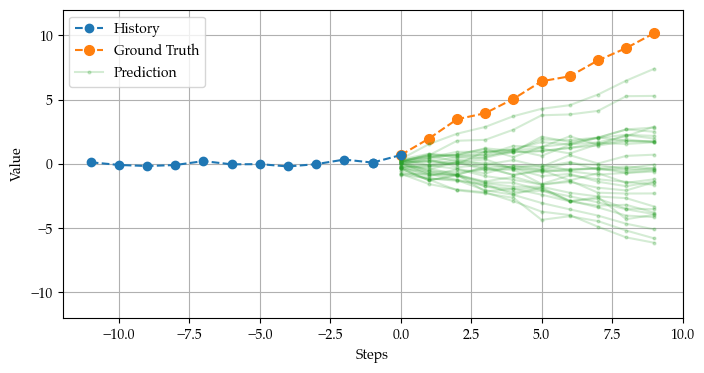

In [123]:
index = 5 # choose an index you want to plot
hw1_helper.plot_data_generative(history=history, future=future, prediction=prediction, index=index, xlims=xlims, ylims=ylims)
